# Import Reuqirements

In [1]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import os
import matplotlib.pyplot as plt
import cv2

# Load Data

In [2]:
#  Data Paths
DATA_PATH_TRAIN = "LEVIR CD/train" 
DATA_PATH_VAL = "LEVIR CD/val"
DATA_PATH_TEST = "LEVIR CD/test"

# Image Size
IMG_SIZE = 256  # reducing the size depends on model

# Data load functions 
def load_image(path, size=IMG_SIZE):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
    img = cv2.resize(img, (size, size))
    img = img / 255.0  # Normalize
    return img

def load_mask(path, size=IMG_SIZE):
    mask = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  
    mask = cv2.resize(mask, (size, size))
    mask = mask / 255.0
    mask = np.expand_dims(mask, axis=-1)  # (H,W,1)
    return mask

def create_dataset(data_path, size=IMG_SIZE, max_samples=500):
    A_path = os.path.join(data_path, "A")
    B_path = os.path.join(data_path, "B")
    label_path = os.path.join(data_path, "label")

    images = []
    masks = []

    file_names = os.listdir(A_path)[:max_samples]

    for fname in file_names:
        imgA = load_image(os.path.join(A_path, fname), size)
        imgB = load_image(os.path.join(B_path, fname), size)
        mask = load_mask(os.path.join(label_path, fname), size)

        # İki görüntüyü yan yana kanal olarak birleştir (6 kanal)
        img = np.concatenate([imgA, imgB], axis=-1)  # (H,W,6)

        images.append(img)
        masks.append(mask)

    images = np.array(images, dtype=np.float32)
    masks = np.array(masks, dtype=np.float32)

    return images, masks

# Load Data
X_train,Y_train = create_dataset(DATA_PATH_TRAIN)
X_val,Y_val = create_dataset(DATA_PATH_VAL)
X_test,Y_test = create_dataset(DATA_PATH_TEST)
print(f"Veri seti şekli: {X_train.shape}, Mask shape: {Y_train.shape}")

Veri seti şekli: (445, 256, 256, 6), Mask shape: (445, 256, 256, 1)


#### Custom model metrics

In [3]:
# This is a performance metric used to evaluate the accuracy of annotation, segmentation, and object detection algorithms.
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_pred = K.cast(y_pred > 0.5, 'float32')
    intersection = K.sum(y_true * y_pred)
    union = K.sum(y_true) + K.sum(y_pred) - intersection
    return (intersection + smooth) / (union + smooth)

# Quantization

In [4]:
# Load main model
model = tf.keras.models.load_model("main_model.h5", custom_objects={'iou_metric': iou_metric})

# Converter Object
converter = tf.lite.TFLiteConverter.from_keras_model(model)

# Opening settings that Post-training quantization
converter.optimizations = [tf.lite.Optimize.DEFAULT]

# We can Feed the process with some data for more correct quantization
def representative_dataset():
    for i in range(100):  
        yield [X_train[i:i+1].astype("float32")]

converter.representative_dataset = representative_dataset

# Creating quantized model
tflite_model = converter.convert()

# Saving model
with open("main_model_quantized.tflite", "wb") as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\HITASK~1\AppData\Local\Temp\tmpe5xbv0is\assets


INFO:tensorflow:Assets written to: C:\Users\HITASK~1\AppData\Local\Temp\tmpe5xbv0is\assets
C:\Users\hitaskomur\anaconda3\envs\tensorflow\lib\site-packages\tensorflow\lite\python\convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


In [5]:
# Loading quantized model(Tflite)
interpreter = tf.lite.Interpreter(model_path="main_model_quantized.tflite")
interpreter.allocate_tensors()

# Get details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

input_shape = input_details[0]['shape']

# Using test data(10) for testing model
num_samples = 10
y_preds = []
y_trues = []

for i in range(num_samples):
    input_data = X_test[i:i+1].astype(np.float32)
    
    interpreter.set_tensor(input_details[0]['index'], input_data)
    interpreter.invoke()
    
    output_data = interpreter.get_tensor(output_details[0]['index'])
    
    y_preds.append((output_data > 0.5).astype(np.uint8))
    y_trues.append((Y_test[i:i+1] > 0.5).astype(np.uint8))

In [6]:
# Flatten
y_pred_flat = np.concatenate(y_preds).flatten()
y_true_flat = np.concatenate(y_trues).flatten()

# Confusion matrix and metrics
cm = confusion_matrix(y_true_flat, y_pred_flat)
print("Confusion Matrix:\n", cm)

print("Precision:", precision_score(y_true_flat, y_pred_flat))
print("Recall:   ", recall_score(y_true_flat, y_pred_flat))
print("F1 Score: ", f1_score(y_true_flat, y_pred_flat))

Confusion Matrix:
 [[617665   5372]
 [  8889  23434]]
Precision: 0.8135110740817885
Recall:    0.7249945858985861
F1 Score:  0.766706473196028


In [7]:
# Loading Main Model
model = tf.keras.models.load_model("main_model.h5", custom_objects={'iou_metric': iou_metric})

y_preds_h5 = (model.predict(X_test[:num_samples]) > 0.5).astype(np.uint8)
y_trues_h5 = (Y_test[:num_samples] > 0.5).astype(np.uint8)

# Flatten
y_pred_flat_h5 = y_preds_h5.flatten()
y_true_flat_h5 = y_trues_h5.flatten()

# Define Paths
h5_path = "main_model.h5"
tflite_path = "main_model_quantized.tflite"

# Boyutları al
h5_size = os.path.getsize(h5_path) / 1024 / 1024  # MB
tflite_size = os.path.getsize(tflite_path) / 1024 / 1024  # MB


1/1 [==============================] - 0s 411ms/step


🔷 Keras Model:
Precision: 0.8032324182655153
Recall:    0.7395662531324444
F1 Score:  0.7700856903550028

🔸 Quantized TFLite Model:
Precision: 0.8135110740817885
Recall:    0.7249945858985861
F1 Score:  0.766706473196028


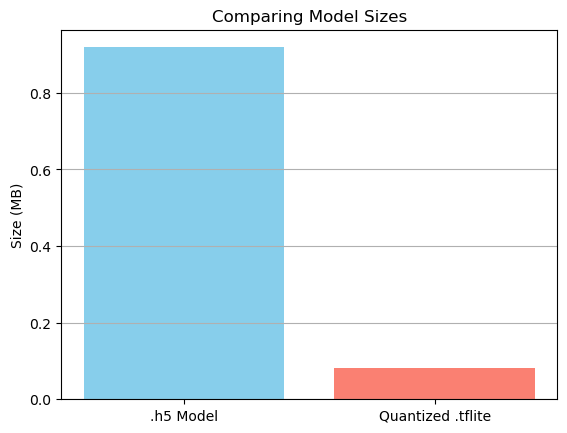

H5 Model Size:     0.92 MB
TFLite Quantized Model Size: 0.08 MB

Quantizing Rate:    11.16 times smaller


In [8]:
print("🔷 Keras Model:")
print("Precision:", precision_score(y_true_flat_h5, y_pred_flat_h5))
print("Recall:   ", recall_score(y_true_flat_h5, y_pred_flat_h5))
print("F1 Score: ", f1_score(y_true_flat_h5, y_pred_flat_h5))

print("\n🔸 Quantized TFLite Model:")
print("Precision:", precision_score(y_true_flat, y_pred_flat))
print("Recall:   ", recall_score(y_true_flat, y_pred_flat))
print("F1 Score: ", f1_score(y_true_flat, y_pred_flat))


sizes = [h5_size, tflite_size]
labels = ['.h5 Model', 'Quantized .tflite']

plt.bar(labels, sizes, color=['skyblue', 'salmon'])
plt.ylabel('Size (MB)')
plt.title('Comparing Model Sizes')
plt.grid(True, axis='y')
plt.show()


print(f"H5 Model Size:     {h5_size:.2f} MB")
print(f"TFLite Quantized Model Size: {tflite_size:.2f} MB")

print(f"\nQuantizing Rate:    {h5_size / tflite_size:.2f} times smaller")